<a href="https://colab.research.google.com/github/DotunOluyade/ShootingVideoClassifier/blob/main/Model_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Evaluate the model
#test_loss, test_accuracy, test_precision, test_recall, test_auc = finetune_model.evaluate(test_dataset)
#print(f"Test Metrics:\n Loss: {test_loss}, Accuracy: {test_accuracy}, Precision: {test_precision}, Recall: {test_recall}, AUC: {test_auc}")

"""# Test Fine-Tuned Model

"""

from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adagrad
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
import cv2


saved_model_path = '/content/drive/MyDrive/VideoAnomalyDetection/pretrained/Video Swin Transformer/TFVideoSwinB_K600_IN22K_P244_W877_32x224'

base_dataset_dir = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/'

def build_finetune_model():
    """
    Fine-tune pretrained model.

    Parameters:
        saved_model_path (str): Path to the saved Video Swin Transformer model.

    Returns:
        model (keras.Model): Fine-tuned model for shooting classification.
    """
    # Load the pretrained Video Swin model
    video_swin = load_model(saved_model_path, compile=False)

    # Fine-tuning configuration: set the last N layers to be trainable
    # N=1, fine-tune the last layer of the pretrained model
    """
    N=1
    for layer in video_swin.layers[:-N]:
        layer.trainable = False
    for layer in video_swin.layers[-N:]:
        layer.trainable = True
    """
    # Set the entire Video Swin model to non-trainable
    video_swin.trainable = False

    # Downstream model for binary classification
    model = Sequential([
        video_swin,
        # Assume video_swin's output shape is compatible with the Dense layer's input
        Dense(512, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),  # Apply L1 regularization
        Dropout(0.6),
        Dense(32, activation='relu', kernel_regularizer=regularizers.l1(1e-5)),  # Apply L1 regularization again if needed
        Dropout(0.6),
        Dense(1, activation='sigmoid')
    ])

    return model

import os


def can_read_file(filepath):
    """
    This function checks the existence of the file and optionally its extension.

    Parameters:
    - filepath: Path to the video file.

    Returns:
    - bool: True if the file exists and has a video file extension; False otherwise.
    """
    # List of common video file extensions for basic filtering.
    video_extensions = ['.avi', '.mp4', '.mov', '.mkv']

    if not os.path.exists(filepath) or not os.path.isfile(filepath):
        return False

    # Check if the file extension is in the list of video extensions.
    file_extension = os.path.splitext(filepath)[1].lower()
    if file_extension not in video_extensions:
        return False

    return True

def read_video_paths_from_file(file_path, base_dataset_dir):
    full_file_path = os.path.join(base_dataset_dir, file_path)

    with open(full_file_path, 'r') as file:
        # Concatenate base_dataset_dir with each path read from the file
        paths = [os.path.join(base_dataset_dir, line.strip()) for line in file]

    return paths

def filter_video_paths(paths, filter_keyword):
    return [path for path in paths if filter_keyword.lower() in path.lower()]


def filter_video_paths_by_anomaly_type(paths, anomaly_type):
    """Filter video paths based on a specific anomaly type."""
    return [path for path in paths if anomaly_type.lower() in path.lower()]

test_file_path = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Temporal_Anomaly_Annotation_for_Testing_Videos_2.txt'


# Read video paths from the file
video_paths = read_video_paths_from_file(test_file_path,base_dataset_dir)

# Use "Shooting" and "Normal" to distinguish the types
anomaly_videos = filter_video_paths(video_paths, 'Shooting')
normal_videos = filter_video_paths(video_paths, 'Normal')

def preprocess_and_segment_video(video_input, resize_shape=(224, 224), segment_length=32):
    frames = []
    is_video_file = isinstance(video_input, str)

    if is_video_file:
        if not os.path.exists(video_input):
            print(f"File does not exist: {video_input}")
            return
        if not can_read_file(video_input):
            print(f"Cannot read file: {video_input}")
            return

        try:
            cap = cv2.VideoCapture(video_input)
            if not cap.isOpened():
                raise IOError(f"OpenCV could not open video file for an unknown reason: {video_input}")
        except Exception as e:
            print(f"Error: {e}")
            return

        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame.size == 0:
                print("Encountered an empty frame in the video.")
                continue
            frame = cv2.resize(frame, resize_shape)
            frame = frame.astype(np.float32) / 255.0
            frames.append(frame)

        cap.release()
    elif isinstance(video_input, (list, np.ndarray)):
        # Additional check for non-empty list/array
        if len(video_input) == 0:
            print("The list/array of frames is empty.")
            return

        frames = video_input
    else:
        raise ValueError("Invalid type for video_input. Must be a file path or list/array of frames.")

    # Segmenting the frames
    for i in range(0, len(frames), segment_length):
        segment_frames = frames[i:i+segment_length]
        if len(segment_frames) < segment_length:
            segment_frames.extend([np.zeros(resize_shape + (3,), dtype=np.float32) for _ in range(segment_length - len(segment_frames))])
        yield np.stack(segment_frames, axis=0)

Loaded weights from the latest checkpoint: /content/drive/MyDrive/VideoAnomalyDetection/training_1/vad_1711700518.ckpt
{'Small_Anomaly/Shooting002_x264.mp4': {'type': 'Shooting', 'intervals': [(1020, 1100)]}, 'Small_Normal/Normal_Videos_603_x264.mp4': {'type': 'Normal', 'intervals': []}, 'Small_Anomaly/Shooting037_x264.mp4': {'type': 'Shooting', 'intervals': [(140, 260)]}}
Total number of videos  3
Evaluating: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Anomaly/Shooting002_x264.mp4
key Small_Anomaly/Shooting002_x264.mp4
video_type anomalous
1/1 [==============================] - 29s 29s/step


<ipython-input-2-6be4985cb070>:152: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = float(model.predict(segment[np.newaxis, ...])[0])


segment_index is 0, segment_start_frame is 0, segment_end_frame is 32, raw prediction is 1.0000, predicted as anomalous? 1, ground truth: is segment anomalous? False
1/1 [==============================] - 21s 21s/step
segment_index is 1, segment_start_frame is 32, segment_end_frame is 64, raw prediction is 1.0000, predicted as anomalous? 1, ground truth: is segment anomalous? False
1/1 [==============================] - 19s 19s/step
segment_index is 2, segment_start_frame is 64, segment_end_frame is 96, raw prediction is 1.0000, predicted as anomalous? 1, ground truth: is segment anomalous? False
1/1 [==============================] - 19s 19s/step
segment_index is 3, segment_start_frame is 96, segment_end_frame is 128, raw prediction is 1.0000, predicted as anomalous? 1, ground truth: is segment anomalous? False
1/1 [==============================] - 24s 24s/step
segment_index is 4, segment_start_frame is 128, segment_end_frame is 160, raw prediction is 1.0000, predicted as anomalous? 

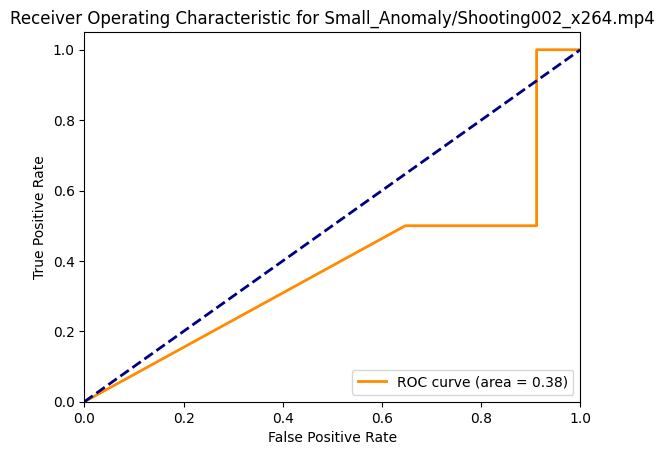

Evaluating: /content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Small_Normal/Normal_Videos_603_x264.mp4
key Small_Normal/Normal_Videos_603_x264.mp4
video_type normal
1/1 [==============================] - 20s 20s/step


<ipython-input-2-6be4985cb070>:152: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = float(model.predict(segment[np.newaxis, ...])[0])


segment_index is 0, segment_start_frame is 0, segment_end_frame is 32, raw prediction is 0.0771, predicted as anomalous? 0, ground truth: is segment anomalous? False
1/1 [==============================] - 20s 20s/step
segment_index is 1, segment_start_frame is 32, segment_end_frame is 64, raw prediction is 0.0848, predicted as anomalous? 0, ground truth: is segment anomalous? False
1/1 [==============================] - 20s 20s/step
segment_index is 2, segment_start_frame is 64, segment_end_frame is 96, raw prediction is 0.0937, predicted as anomalous? 0, ground truth: is segment anomalous? False
1/1 [==============================] - 21s 21s/step
segment_index is 3, segment_start_frame is 96, segment_end_frame is 128, raw prediction is 0.1358, predicted as anomalous? 0, ground truth: is segment anomalous? False
1/1 [==============================] - 19s 19s/step
segment_index is 4, segment_start_frame is 128, segment_end_frame is 160, raw prediction is 0.6018, predicted as anomalous? 

<ipython-input-2-6be4985cb070>:152: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prediction = float(model.predict(segment[np.newaxis, ...])[0])


1/1 [==============================] - 18s 18s/step
segment_index is 1, segment_start_frame is 32, segment_end_frame is 64, raw prediction is 1.0000, predicted as anomalous? 1, ground truth: is segment anomalous? False
1/1 [==============================] - 19s 19s/step
segment_index is 2, segment_start_frame is 64, segment_end_frame is 96, raw prediction is 1.0000, predicted as anomalous? 1, ground truth: is segment anomalous? False
1/1 [==============================] - 17s 17s/step
segment_index is 3, segment_start_frame is 96, segment_end_frame is 128, raw prediction is 1.0000, predicted as anomalous? 1, ground truth: is segment anomalous? False
1/1 [==============================] - 18s 18s/step
segment_index is 4, segment_start_frame is 128, segment_end_frame is 160, raw prediction is 1.0000, predicted as anomalous? 1, ground truth: is segment anomalous? True
1/1 [==============================] - 19s 19s/step
segment_index is 5, segment_start_frame is 160, segment_end_frame is 1

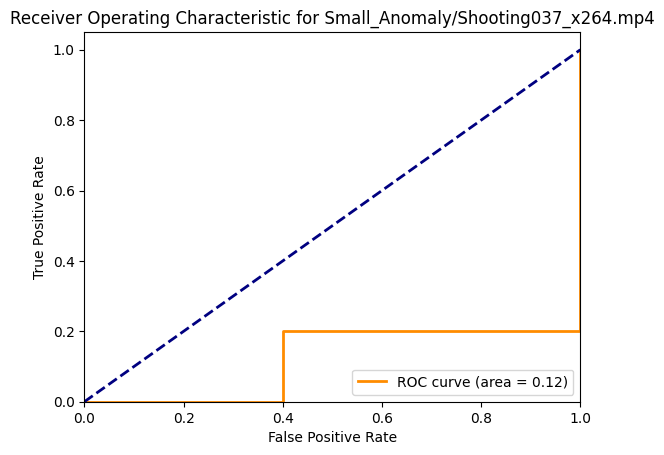

Average scores for anomalous videos: {'precision': 0.3026315789473684, 'recall': 1.0, 'f1': 0.42857142857142855, 'accuracy': 0.3026315789473684, 'auc': 0.2511764705882353}
Average scores for normal videos: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.7572815533980582, 'auc': nan}


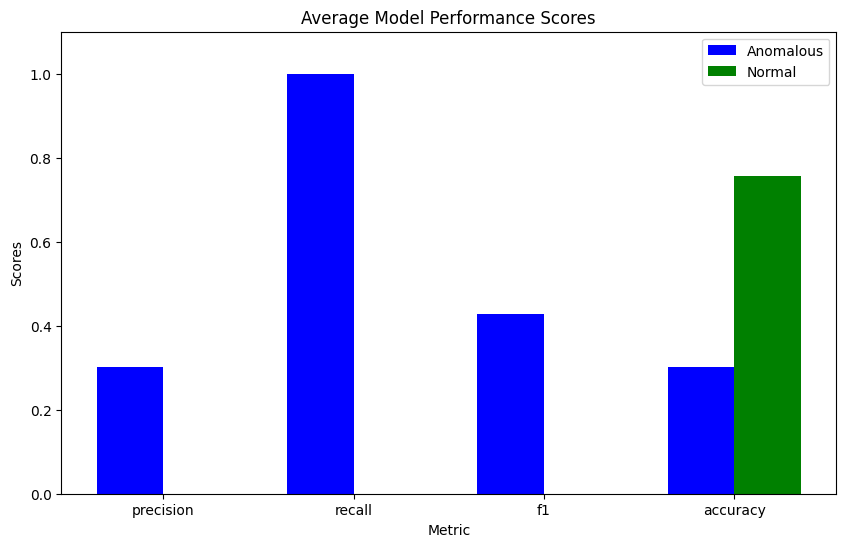

In [2]:
"""#Load Model Weights for Inference"""

import tensorflow as tf
import numpy as np
import os


checkpoint_dir = "/content/drive/MyDrive/VideoAnomalyDetection/training_1"
test_file_path = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Temporal_Anomaly_Annotation_for_Testing_Videos_2.txt'

model = build_finetune_model()

# Load the latest checkpoint
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

# Check if there is any checkpoint available and load the model or weights
if latest_checkpoint:
    #If loading the entire model (architecture + weights)
    #model = tf.keras.models.load_model(latest_checkpoint)
    model.load_weights(latest_checkpoint)
    print(f"Loaded weights from the latest checkpoint: {latest_checkpoint}")
else:
    print("No checkpoint found. Ensure your checkpoint directory is correct.")

"""#Prepare Test Videos

# Test Model Performance with Test Videos
"""

def load_annotations_from_txt(file_path):
    """
    Load annotations from a plain text file and parse them into a structured dictionary.

    Expected file format: video_path anomaly_type start1 end1 start2 end2 ...
    '-1 -1' indicates the end of annotations for that video.

    Parameters:
    - file_path: Path to the text file containing annotations.

    Returns:
    - A dictionary with video paths as keys and their annotations (types and intervals) as values.
    """
    annotations = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if not parts:  # Skip empty lines
                continue

            video_path, anomaly_type = parts[0], parts[1]
            intervals = [(int(parts[i]), int(parts[i+1])) for i in range(2, len(parts), 2) if int(parts[i]) >= 0]

            annotations[video_path] = {
                'type': anomaly_type,
                'intervals': intervals
            }

    return annotations

print(load_annotations_from_txt("/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Temporal_Anomaly_Annotation_for_Testing_Videos_2.txt"))

def extract_features_with_segments(model, video_path, resize_shape=(224, 224), segment_length=32):
    features = []
    for segment in preprocess_and_segment_video(video_path, resize_shape, segment_length):
        # Assuming the model can take a 4D input and return a feature vector or classification per segment
        segment_features = model.predict(segment[np.newaxis, ...])
        features.append(segment_features)
    return np.array(features)

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score


def validate_binary_targets(y_true, y_pred):
    # Convert to integers if they're not already
    y_true = [int(y) for y in y_true]
    y_pred = [int(y) for y in y_pred]

    # Check for equal length
    if len(y_true) != len(y_pred):
        raise ValueError("y_true and y_pred must be of the same length.")

    # Check for binary values only
    if set(y_true) > {0, 1} or set(y_pred) > {0, 1}:
        raise ValueError("Targets must be binary (0 or 1).")

    return y_true, y_pred

def classify_video(prediction_scores, threshold=0.5):
    """
    Classify a video as 'Shooting' or 'Normal' based on the mean prediction score.

    Parameters:
    - prediction_scores: A list of prediction scores for the video segments or frames.
    - threshold: The threshold for classification. Default is 0.5.

    Returns:
    - A string indicating the classification ('Shooting' or 'Normal').
    """

    # Compute the mean prediction score
    mean_score = sum(prediction_scores) / len(prediction_scores)

    # Apply the classification threshold
    if mean_score > threshold:
        return 'Shooting'
    else:
        return 'Normal'

# Thresholding to obtain binary predictions
threshold = 0.6

def evaluate_model(model, video_paths, annotations, base_dataset_dir, resize_shape=(224, 224), segment_length=32):
    """
    Evaluate the model's performance separately for normal and anomalous videos.

    Parameters:
    - model: The trained model to evaluate.
    - video_paths: List of video paths.
    - annotations: Dictionary containing anomaly annotations for the videos.
    - base_dataset_dir: Base directory where video files are stored.
    - resize_shape: The shape to resize each frame of the video.
    - segment_length: Number of frames per segment.
    """

    # Initialize lists to store scores for anomalous and normal videos separately
    scores = {
        'anomalous': {'precision': [], 'recall': [], 'f1': [], 'accuracy': [], 'auc': []},
        'normal': {'precision': [], 'recall': [], 'f1': [], 'accuracy': [], 'auc': []}
    }

    print('Total number of videos ', len(video_paths))

    for video_path in video_paths:
        if not os.path.exists(video_path):
            print(f"Warning: File does not exist {video_path}, skipping.")
            continue
        print('Evaluating:', video_path)
        path_parts = video_path.split('/')
        key = '/'.join(path_parts[-2:])
        print('key',key)
        video_annotations = annotations.get(key, {}).get('intervals', [])

        # Assume all videos without annotations are normal
        video_type = 'normal' if not video_annotations else 'anomalous'
        print('video_type',video_type)


        segment_predictions, segment_truths, segment_scores = [], [], []
        segment_index = 0

        for segment in preprocess_and_segment_video(video_path, resize_shape, segment_length):
            prediction = float(model.predict(segment[np.newaxis, ...])[0])

            # Apply threshold to determine if the segment is predicted as anomalous or normal
            predicted_as_anomalous = int(prediction > threshold)  # higher scores indicate anomalies

            segment_start_frame = segment_index * segment_length
            segment_end_frame = segment_start_frame + segment_length
            is_anomalous = any(start <= segment_end_frame and end >= segment_start_frame for start, end in video_annotations)

            print("segment_index is {}, segment_start_frame is {}, segment_end_frame is {}, raw prediction is {:.4f}, predicted as anomalous? {}, ground truth: is segment anomalous? {}".format(
            segment_index, segment_start_frame, segment_end_frame, prediction, predicted_as_anomalous, is_anomalous))

            # Append the prediction and truth for the current segment
            segment_predictions.append(predicted_as_anomalous)
            segment_truths.append(int(is_anomalous))
            segment_scores.append(prediction)  # Append raw prediction score here

            segment_index += 1

        # Calculate metrics for this video
        precision, recall, f1, _ = precision_recall_fscore_support(segment_truths, segment_predictions, average='binary', zero_division=0)
        accuracy = accuracy_score(segment_truths, segment_predictions)
        # Before calculating the AUC score, check if both classes are present
        unique_classes = np.unique(segment_truths)


        classification = classify_video(segment_scores, threshold)
        print(f"\nVideo {video_path} is classified as: {classification}")

        if len(unique_classes) > 1:
            auc = roc_auc_score(segment_truths, segment_scores)
            fpr, tpr, thresholds = roc_curve(segment_truths, segment_scores)

            scores[video_type]['auc'].append(auc)
            print(f"Video: {key}\nPrecision: {precision}, Recall: {recall}, F1 Score: {f1}, AUC: {auc}, FPR: {fpr}, TPR: {tpr}\n")

            # Plot the ROC curve for the current video
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic for {key}')
            plt.legend(loc="lower right")
            plt.show()
        else:
            print(f"Video: {key}\nPrecision: {precision}, Recall: {recall}, F1 Score: {f1}\nAUC cannot be calculated because only one class is present.")
            auc = np.nan  # -1, to indicate it's not calculated
            scores[video_type]['auc'].append(auc)

        # Store the scores based on video type
        scores[video_type]['precision'].append(precision)
        scores[video_type]['recall'].append(recall)
        scores[video_type]['f1'].append(f1)
        scores[video_type]['accuracy'].append(accuracy)

    # Calculate average scores for anomalous and normal videos
    avg_scores = {}
    for type_ in ['anomalous', 'normal']:
        avg_scores[type_] = {
            metric: np.mean(values) for metric, values in scores[type_].items()
        }

    return avg_scores

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Read video paths from the file
video_paths = read_video_paths_from_file(test_file_path,base_dataset_dir)
# Use "Shooting" and "Normal" to distinguish the types
# Extract the actual path from the annotation line, if not already a clean path
clean_video_paths = [path.split()[0] for path in video_paths]
annotation_path = '/content/drive/MyDrive/VideoAnomalyDetection/data/UCF-Crime/Temporal_Anomaly_Annotation_for_Testing_Videos_2.txt'
annotations = load_annotations_from_txt(annotation_path)
# `clean_video_path` is a list of video paths, `annotations` is your annotations dictionary, and `model` is your trained model
avg_scores = evaluate_model(model, clean_video_paths, annotations, base_dataset_dir)
print("Average scores for anomalous videos:", avg_scores['anomalous'])
print("Average scores for normal videos:", avg_scores['normal'])

# Example categories
categories = ['precision', 'recall', 'f1', 'accuracy']

# Assuming avg_scores is defined as shown above
anomalous_scores = [avg_scores['anomalous'][metric] for metric in categories]
normal_scores = [avg_scores['normal'][metric] for metric in categories]

# Indices of the categories
ind = np.arange(len(categories))
width = 0.35

plt.figure(figsize=(10, 6))

# Plotting anomalous and normal scores side by side for each category
plt.bar(ind - width/2, anomalous_scores, width, label='Anomalous', color='blue')
plt.bar(ind + width/2, normal_scores, width, label='Normal', color='green')

plt.xlabel('Metric')
plt.ylabel('Scores')
plt.title('Average Model Performance Scores')
plt.xticks(ind, categories)
plt.legend(loc='best')
plt.ylim(0, 1.1)  # Assuming scores are between 0 and 1

plt.show()